In [1]:
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Conv2D,GlobalMaxPooling2D,SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
challenge_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/JanathaHack/RecommendationSystems/challenge_data.csv")
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/JanathaHack/RecommendationSystems/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/JanathaHack/RecommendationSystems/test.csv")
sub = pd.read_csv("/content/drive/My Drive/Colab Notebooks/JanathaHack/RecommendationSystems/sample_sub.csv")
train.drop("user_sequence",axis=1,inplace=True)
test.drop("user_sequence",axis=1,inplace=True)

# merge_train = pd.merge(train,challenge_data,on=["challenge"],how="left")
# merge_test = pd.merge(test,challenge_data,on=["challenge"],how="left") 

# merge_train
train

,user_id,challenge_sequence,challenge
0,4576,1,CI23714
1,4576,2,CI23855
2,4576,3,CI24917
3,4576,4,CI23663
4,4576,5,CI23933
...,...,...,...
903911,113839,9,CI24992
903912,113839,10,CI28586
903913,113839,11,CI28610
903914,113839,12,CI26388


In [3]:
concat_train = train.groupby("user_id").agg({"challenge": lambda x: ' '.join(set(x.dropna()))})

In [4]:
concat_train = concat_train.reset_index(drop=True)
concat_train["challenge"]

0        CI23933 CI24917 CI23975 CI24957 CI24958 CI2512...
1        CI23933 CI23975 CI24530 CI25727 CI23667 CI2378...
2        CI26159 CI26160 CI26165 CI26164 CI26162 CI2616...
3        CI23933 CI24917 CI23975 CI24958 CI24957 CI2494...
4        CI23933 CI23975 CI24917 CI24958 CI24530 CI2512...
                               ...                        
69527    CI24435 CI23933 CI24530 CI24521 CI24445 CI2443...
69528    CI23769 CI23933 CI24875 CI24869 CI25023 CI2486...
69529    CI24930 CI26621 CI24958 CI24230 CI23836 CI2605...
69530    CI24892 CI23990 CI23933 CI25049 CI24866 CI2487...
69531    CI25727 CI24954 CI28610 CI28630 CI28328 CI2858...
Name: challenge, Length: 69532, dtype: object

In [5]:
outF = open("concat_train.txt", "w")
for i in concat_train["challenge"].values:
  outF.write(i)
  outF.write("\n")
outF.close()

In [6]:
tokenizer = Tokenizer()

data = open('concat_train.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'ci23855': 1, 'ci23714': 2, 'ci24917': 3,..... }
5349


In [15]:
input_sequences_x = []
input_y=[]
for line in corpus:
 token_list = tokenizer.texts_to_sequences([line])[0]
 n_gram_sequence = token_list[:-3]
 input_sequences_x.append(n_gram_sequence)
 input_y.append(token_list[-3:])

In [ ]:
# input_sequences = []
# for line in corpus:
# 	token_list = tokenizer.texts_to_sequences([line])[0]
# 	for i in range(1, len(token_list)):
# 		n_gram_sequence = token_list[:i+1]
# 		input_sequences.append(n_gram_sequence)

In [ ]:
input_sequences_x[:10]

[[7, 11, 35, 14, 9, 5, 2, 37, 1, 4],
 [19, 7, 14, 8, 2, 37, 100, 1, 104, 6],
 [219, 191, 354, 297, 192, 251, 259, 315, 222, 249],
 [7, 35, 14, 5, 2, 116, 30, 1, 4, 6],
 [7, 11, 14, 5, 8, 2, 21, 1, 4, 6],
 [889, 14, 62, 92, 501, 37, 1, 104, 34, 6],
 [7, 149, 424, 9, 31, 2, 28, 1, 276, 3],
 [19, 7, 3, 14, 29, 17, 8, 5, 2, 15],
 [7, 11, 5, 2, 21, 13, 28, 1, 4, 31],
 [219, 191, 354, 297, 192, 251, 259, 315, 222, 280]]

In [16]:
# pad sequences 
max_sequence_len = 13
input_sequences_x = pad_sequences(input_sequences_x, maxlen=13, padding='post')
input_y = np.asarray(input_y)

In [10]:
input_sequences_x[:10]#input_x

array([[  6,   3,  18,  35,   5,  11,  37,   9,   2,  14,   0,   0,   0],
       [  6,  18,   8, 104,  37, 100,  34,  19,   2,  14,   0,   0,   0],
       [251, 297, 212, 191, 219, 315, 354, 259, 192, 261,   0,   0,   0],
       [  6,   3,  18,   5,  35, 116,  34,   2,   7,  30,   0,   0,   0],
       [  6,  18,   3,   5,   8,  11,  10,   4,   2,  21,   0,   0,   0],
       [  6, 501,  92, 104,  62,  43,  37,   1,  34, 889,   0,   0,   0],
       [149,  18,   3, 276,  10,   4,   2,   9, 424,  31,   0,   0,   0],
       [  6,   8,  17,   3,   5,  15,  29,  19,   2,   7,   0,   0,   0],
       [ 13,   3,  18,   5,  11,  10,   4,   2,  21,  31,   0,   0,   0],
       [251, 297, 212, 191, 219, 315, 354, 259, 192, 280,   0,   0,   0]],
      dtype=int32)

In [20]:
[x for x in input_y[:10]]#input_y

[[7, 4, 1],
 [7, 4, 1],
 [222, 281, 249],
 [14, 4, 1],
 [7, 1, 14],
 [23, 4, 14],
 [7, 1, 28],
 [14, 4, 1],
 [7, 1, 28],
 [261, 222, 249]]

In [21]:
input_sequences_x.shape,len(input_y)

((69533, 13), 69533)

In [25]:
xs = tf.keras.utils.to_categorical(input_sequences_x, num_classes=total_words,dtype='int8')
ys = tf.keras.utils.to_categorical(input_y, num_classes=total_words,dtype='int8')

In [ ]:
# ys = np.array(ys,dtype=np.float16)

In [ ]:
input_sequences.shape,ys.shape

((834384, 13), (834384, 5349))

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1,mask_zero=True))
# model.add(Conv2D(128, 5, activation='relu'))
# model.add(GlobalMaxPooling2D())
model.add(Bidirectional(LSTM(128)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=10,validation_split=0.05, verbose=1)
#print model.summary()
print(model)

In [ ]:
model.save('my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 13)            69537     
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               145408    
_________________________________________________________________
dense (Dense)                (None, 5349)              1374693   
Total params: 1,589,638
Trainable params: 1,589,638
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

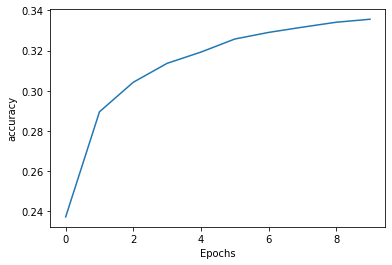

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
concat_test = test.groupby("user_id").agg({"challenge": lambda x: ' '.join(set(x.dropna()))})
concat_test = concat_test.reset_index(drop=True)
concat_test["challenge"][0]

'CI24915 CI24917 CI24958 CI24530 CI23663 CI23714 CI25135 CI25727 CI23855 CI23933'

In [ ]:

def getop(seed_text,next_words):  
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word.upper()
  return seed_text.split(" ")[-3:]

In [ ]:
%%time
op_list = []
for i in range(len(concat_test)):
  seed_text = concat_test["challenge"][i]
  next_words = 3
  op_list.append(getop(seed_text,next_words))

CPU times: user 1h 2min 4s, sys: 2min 51s, total: 1h 4min 55s
Wall time: 58min 56s


In [ ]:
# %%time
# seed_text = concat_test["challenge"][1]
# next_words = 3
# display(getop(seed_text,next_words))

In [ ]:
sub["challenge"] = np.array(op_list).reshape(-1,1)

In [ ]:
sub

,user_sequence,challenge
0,4577_11,CI23836
1,4577_12,CI23663
2,4577_13,CI26051
3,4578_11,CI23836
4,4578_12,CI23663
...,...,...
119191,113834_12,CI24935
119192,113834_13,CI24924
119193,113838_11,CI23714
119194,113838_12,CI23663


In [ ]:
sub.drop("challenge_out",axis=1,inplace=True)

In [ ]:
sub.to_csv("submit.csv",index=False)